In [1]:
import os
import json

def get_data(folder_name):
    x = []
    y = []
    positions = []
    file_names = []

    for file in os.listdir(folder_name):
        if file.endswith(".txt"):
            file_name = os.path.join(folder_name, file[:-4])

            file_text = open(file_name + '.txt', encoding='utf8')
            try:
                file_truth = open(file_name + '.truth', encoding='utf8')

                try:
                    text = file_text.read()
                    truth = json.load(file_truth)
                    truth_changes = truth['changes']
                    truth_positions = truth['positions']

                    x.append(text)
                    y.append(truth_changes)
                    positions.append(truth_positions)
                    file_names.append(file[:-4])
                finally:
                    file_truth.close()
            finally:
                file_text.close()

    return x, y, positions, file_names

In [2]:
from nltk.tokenize import sent_tokenize, word_tokenize
def custom_sent_tokenize(text):
    sentences = []
    paragraphs = [p for p in text.split('\n') if p]
    for paragraph in paragraphs:
        sentences.extend(sent_tokenize(paragraph))
        
    return sentences

In [3]:
def segment_tokenize(text, n=10):
    segments = []
    sentences = custom_sent_tokenize(text)
    x = len(sentences)
    i = 0
    for i in range(0, x-x%n, n):
        segments.append(''.join(sentences[i:i+n]))
    segments.append(''.join(sentences[i:]))
    
    return segments

In [4]:
import pandas as pd

TRAINING_DIR = '../data/training'

X, y, positions, file_names = get_data(
    TRAINING_DIR)
df = pd.DataFrame(data={'text': X, 'label': y, 'filename': file_names, 'pos':positions})
df['num_sent'] = [len(custom_sent_tokenize(d)) for d in df.text]
df['num_splits'] = [len(x) for x in df.pos]

In [7]:
from nltk import pos_tag
def pos_tags(text):
    result = ''
    words = pos_tag(word_tokenize(text.lower()))
    for w, t in words:
        result=result+' '+ t
        
    return result

In [8]:
pos_tags(df.text[0])

" RB VB NN VBG IN PRP$ NN IN PRP VBZ DT NN RB VB RP WRB JJ PRP$ NN VBZ . WP VBZ DT NN POS JJ CD NN NN . JJ NN . JJ NN NN . DT RB JJ NN MD VB PRP TO VB PRP$ NN IN DT JJ NN NNS . NN DT PRP$ NNS CC DT NN PRP VBD TO VB DT NN IN VBG PRP$ NN ( JJ ) . VB JJ PRP$ NN VBZ DT NN IN DT NNS PRP VBD TO VB . VB JJ IN PRP$ NN IN VBG DT NN NN CC VB DT NN NN RB IN DT JJ NN IN RBS , NN , CC JJS NN NNS . PRP MD VB DT NNS IN JJ IN JJ NN NNS CC NNS IN NN NN IN PRP VBP . VB PRP$ NNS IN DT NN TO VB NNS VBP RB VB DT JJ NN NNS VBN IN PRP$ NN NNS . DT NN MD VB VBN RB IN DT NN TO VB CC VB NNS WDT MD VB VBN TO VB DT NN POS JJ NN NNS . PRP MD VB DT NN NN , NN NN , NN NN , FW IN VBG DT JJ NN NN ( IN NN ) IN DT NNS JJ NN CC : WRB VBP VB VB DT JJ NN NNS . JJS JJ NNS VBP RB IN DT NN IN DT JJ NNS PRP VBP RB VBN DT NN . VBG DT JJ NN IN PRP VBP IN . NN NN VBD NNS , CC DT NN NN VBZ RB DT JJR NN . JJ NNS VBP JJ NNS . PRP VBP DT NN IN NN TO NN RB IN DT NN VBN NN . DT VBZ DT NN NN , IN VBG MD VB NN IN DT NN IN VBN . WP VBZ VB

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
import numpy as np

def word_vectors(data):
    vectors = []
    vect = TfidfVectorizer(max_features=50, ngram_range=(1, 2))
    vect.fit([pos_tags(d) for d in data])
    
    for d in data:
        segments = segment_tokenize(d)
        train_x = vect.transform([pos_tags(s) for s in segments]).toarray()
        vectors.append(np.std(train_x, axis=0))
    
    return vectors, vect.get_feature_names()

In [42]:
X, names = word_vectors(df.text)

In [43]:
X = np.array(X)

In [44]:
for i in range(len(names)):
    df[names[i]] = X[:,i]

In [45]:
names

['cc',
 'cd',
 'dt',
 'dt jj',
 'dt nn',
 'dt nns',
 'in',
 'in dt',
 'in jj',
 'in nn',
 'in prp',
 'jj',
 'jj in',
 'jj nn',
 'jj nns',
 'md',
 'md vb',
 'nn',
 'nn cc',
 'nn dt',
 'nn in',
 'nn nn',
 'nn nns',
 'nn prp',
 'nn rb',
 'nn to',
 'nn vbz',
 'nns',
 'nns in',
 'prp',
 'prp nn',
 'prp vbp',
 'prp vbz',
 'rb',
 'rb in',
 'rb jj',
 'rb vb',
 'to',
 'to vb',
 'vb',
 'vb dt',
 'vb in',
 'vbd',
 'vbg',
 'vbn',
 'vbn in',
 'vbp',
 'vbz',
 'vbz dt',
 'vbz rb']

In [46]:
from sklearn.feature_selection import SelectKBest, chi2
ch2 = SelectKBest(chi2, k=20)
X_train = ch2.fit_transform(X, df.label)
best = [names[i] for i in ch2.get_support(indices=True)]

In [47]:
np.mean(ch2.scores_)

0.4941365224145528

In [48]:
best

['cd',
 'dt',
 'dt nn',
 'in',
 'in dt',
 'jj',
 'jj nn',
 'md',
 'nn',
 'nn in',
 'nn nn',
 'nns',
 'prp',
 'rb',
 'to',
 'to vb',
 'vb',
 'vbd',
 'vbp',
 'vbz']

c:\users\didi\appdata\local\programs\python\python35\lib\site-packages\matplotlib\pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


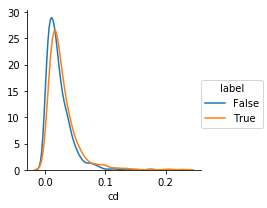

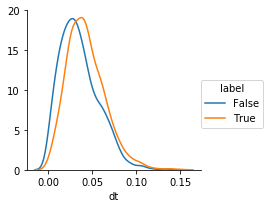

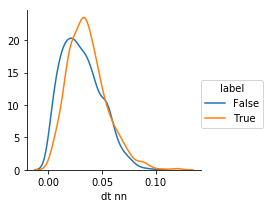

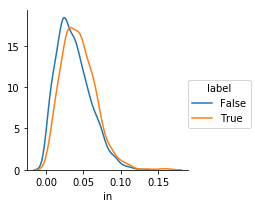

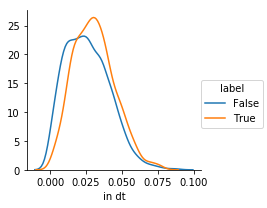

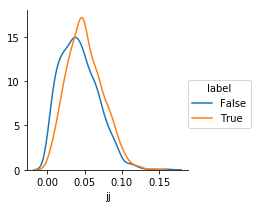

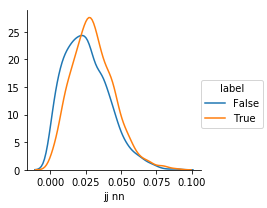

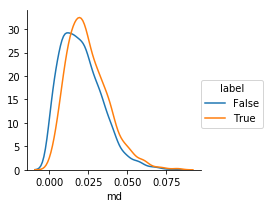

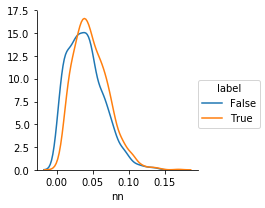

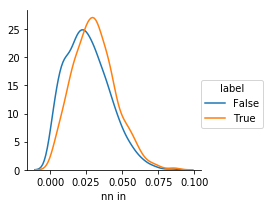

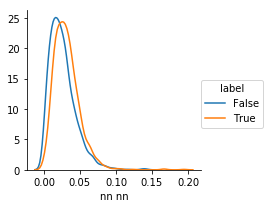

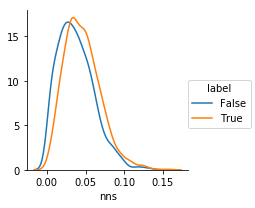

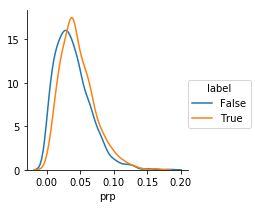

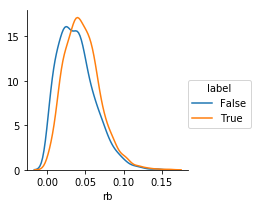

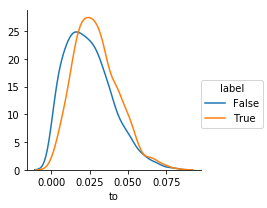

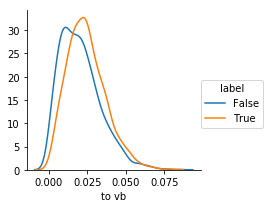

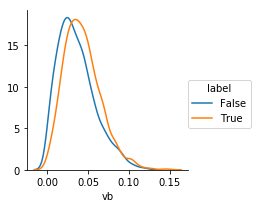

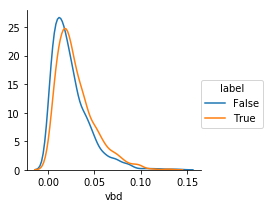

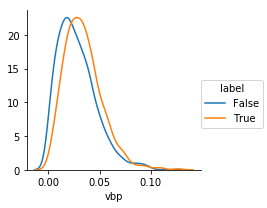

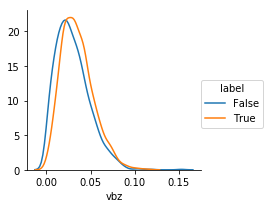

In [49]:
import seaborn as sns
for name in best:
    plt.figure()
    sns.FacetGrid(df, hue="label") \
       .map(sns.kdeplot, name) \
       .add_legend()